In [1]:
import tensorflow as tf
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import collections
import math
import os
import sys
from six.moves import urllib
import zipfile
import random
from six.moves import xrange

In [2]:
def read_data(ns_data):
    words=[]
    for ns in ns_data:
        #data= tf.compat.as_str(ns).split()
        words.extend(ns.split())
        
    print(type(words),len(words))
    return words

In [3]:
data_index = 0
def generate_batch(data, batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            context[i * num_skips + j, 0] = buffer[target]  # these are the context words
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, context

In [4]:
# Python optimisation variables
learning_rate = 0.1
epochs = 2000
batch_size = 256

In [5]:
def randomn_selection(X_train,label_train,k):
    idx = np.random.randint(X_train.shape[0], size=k)
    return X_train[idx],label_train[idx]

In [6]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [7]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
newsgroups_train = fetch_20newsgroups(subset="train")
from sklearn.feature_extraction import stop_words
newsgroups_trainlabel = newsgroups_train.target
vectorizer = TfidfVectorizer()
vectorstrain = vectorizer.fit_transform(newsgroups_train.data)
newsgroups_test = fetch_20newsgroups(subset="test")
vocab = vectorizer.vocabulary_
newvectorizer = TfidfVectorizer(vocabulary=vocab)
vectorstest = newvectorizer.fit_transform(newsgroups_test.data)
newsgroups_testlabel = newsgroups_test.target

In [8]:
vocabulary = read_data(newsgroups_train.data)
data, count, dictionary, reversed_dictionary = build_dataset(vocabulary,50000)

<class 'list'> 3252437


In [9]:
print(len(dictionary))

50000


In [10]:
# vocabsize = len(vocab)
# hot_vector_label_train = np.zeros((newsgroups_trainlabel.shape[0],20))
# print(hot_vector_label_train.shape)
# index = 0
# for label in newsgroups_trainlabel:
#     #print(label)
#     hot_vector_label_train[index][int(label)] = 1
#     index += 1

# print(hot_vector_label_train)

# index = 0

# hot_vector_label_test = np.zeros((newsgroups_testlabel.shape[0],20))
# print(hot_vector_label_test.shape)
# index = 0
# for label in newsgroups_testlabel:
#     #print(label)
#     hot_vector_label_test[index][int(label)] = 1
#     index += 1

# print(hot_vector_label_test)

In [11]:
batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a context.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
vocabulary_size = 50000
num_sampled = 64    # Number of negative examples to sample.

In [21]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_context = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Look up embeddings for inputs.
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    

  # Construct the variables for the softmax
    weights = tf.Variable(
    tf.truncated_normal([embedding_size, vocabulary_size],
                          stddev=1.0 / math.sqrt(embedding_size)))
    biases = tf.Variable(tf.zeros([vocabulary_size]))
    hidden_out = tf.transpose(tf.matmul(tf.transpose(weights), tf.transpose(embed))) + biases

  # convert train_context to a one-hot format
    train_one_hot = tf.one_hot(train_context, vocabulary_size)

    nce_loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_context,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))
    
    
  # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(nce_loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
    init = tf.global_variables_initializer()
    
    
    session = tf.Session(graph=graph)
    #We must initialize all variables before we use them.
    init.run(session=session)
    print('Initialized')
    num_steps = 70000

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_context = generate_batch(data,batch_size, num_skips, skip_window)

        feed_dict = {train_inputs: batch_inputs, train_context: batch_context}

            #We perform one update step by evaluating the optimizer op (including it
            #in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, nce_loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
             if step > 0:
                average_loss /= 1000
              #The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step ', step, ': ', average_loss)
                average_loss = 0
    final_embeddings = normalized_embeddings.eval(session=session)

Initialized
Average loss at step  1000 :  149.40976762008668
Average loss at step  2000 :  95.16504928970338
Average loss at step  3000 :  72.57889421844483
Average loss at step  4000 :  51.38953950977326
Average loss at step  5000 :  45.92273817062378
Average loss at step  6000 :  33.33767828321457
Average loss at step  7000 :  30.538573732376097
Average loss at step  8000 :  51.31745117473602
Average loss at step  9000 :  24.407687687397004
Average loss at step  10000 :  19.438592584848404
Average loss at step  11000 :  17.025978537082672
Average loss at step  12000 :  14.201082150459289
Average loss at step  13000 :  189.96593912887573
Average loss at step  14000 :  18.615953506946564
Average loss at step  15000 :  17.54619958305359
Average loss at step  16000 :  12.462354228973389
Average loss at step  17000 :  11.09464746427536
Average loss at step  18000 :  10.889214370012283
Average loss at step  19000 :  9.572897600650787
Average loss at step  20000 :  18.046160798549653
Averag

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
dist_matrix = cosine_similarity(final_embeddings)

In [23]:
indexestrain = np.argpartition(dist_matrix,-20,axis=1)[:,-20:]

In [44]:
def lookup(index):
    temp = ""
    for j in indexestrain[index]:   
        temp += " " + reversed_dictionary[j]
    print(reversed_dictionary[index] + " " + temp)

then  so [DD] thought | but will far states then when it SVGA, he where sts@mfltd.co.uk I facility and (leads mindset


In [45]:
lookup(7)

in  xxxx about when into - at for on that with as in is by and | from of to UNK


In [46]:
dictionary

jesus  º Teemu 2130 gmw0622@venus.tamu.edu JOHN sake instructors :|> Vinge processed J19 /lib/libX11.so Judea, [FARID] mormon calibrated jesus '030 sysmgr@king.eng.umd.edu >-the


In [47]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)

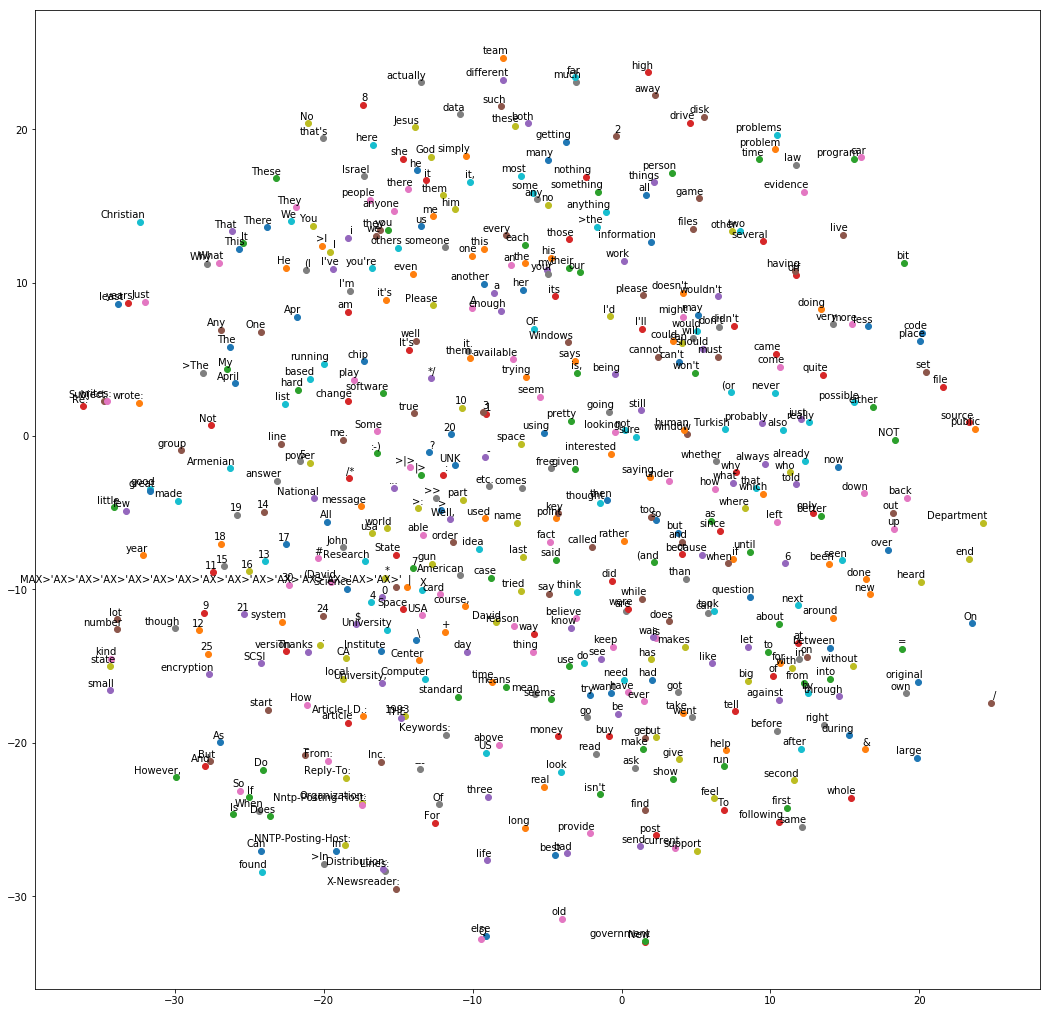

In [50]:
try:
  # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reversed_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, 'tsne.png')

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)